In [1]:
# #从OBS桶下载数据集
# !wget https://professional-construction.obs.cn-north-4.myhuaweicloud.com:443/deep-learning/fashion-mnist.zip
# #解压文件
# !unzip fashion-mnist.zip

In [2]:
import os
import struct
import sys
from easydict import EasyDict as edict

import matplotlib.pyplot as plt
import numpy as np

import mindspore
import mindspore.dataset as ds
import mindspore.nn as nn
from mindspore import context
from mindspore.nn.metrics import Accuracy
from mindspore.train import Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor
from mindspore import Tensor

context.set_context(mode=context.GRAPH_MODE, device_target='Ascend')

In [3]:
cfg = edict({
    'train_size': 60000,  # 训练集大小
    'test_size': 10000,  # 测试集大小
    'channel': 1,  # 图片通道数
    'image_height': 28,  # 图片高度
    'image_width': 28,  # 图片宽度
    'batch_size': 64,
    'num_classes': 10,  # 分类类别
    'lr': 0.001,  # 学习率
    'epoch_size': 20,  # 训练次数
    'data_dir_train': os.path.join('fashion-mnist', 'train'),
    'data_dir_test': os.path.join('fashion-mnist', 'test'),
})

In [4]:
def read_image(file_name):
    '''
    :param file_name: 文件路径
    :return:  训练或者测试数据
    如下是训练的图片的二进制格式
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000803(2051) magic number
    0004     32 bit integer  60000            number of images
    0008     32 bit integer  28               number of rows
    0012     32 bit integer  28               number of columns
    0016     unsigned byte   ??               pixel
    0017     unsigned byte   ??               pixel
    ........
    xxxx     unsigned byte   ??               pixel
    '''
    file_handle = open(file_name, "rb")  # 以二进制打开文档
    file_content = file_handle.read()  # 读取到缓冲区中
    head = struct.unpack_from('>IIII', file_content, 0)  # 取前4个整数，返回一个元组
    offset = struct.calcsize('>IIII')
    imgNum = head[1]  # 图片数
    width = head[2]  # 宽度
    height = head[3]  # 高度
    bits = imgNum * width * height  # data一共有60000*28*28个像素值
    bitsString = '>' + str(bits) + 'B'  # fmt格式：'>47040000B'
    imgs = struct.unpack_from(bitsString, file_content, offset)  # 取data数据，返回一个元组
    imgs_array = np.array(imgs, np.float32).reshape((imgNum, width * height))  # 最后将读取的数据reshape成 【图片数，图片像素】二维数组
    return imgs_array


def read_label(file_name):
    '''
    :param file_name:
    :return:
    标签的格式如下：
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000801(2049) magic number (MSB first)
    0004     32 bit integer  60000            number of items
    0008     unsigned byte   ??               label
    0009     unsigned byte   ??               label
    ........
    xxxx     unsigned byte   ??               label
    The labels values are 0 to 9.
    '''
    file_handle = open(file_name, "rb")  # 以二进制打开文档
    file_content = file_handle.read()  # 读取到缓冲区中
    head = struct.unpack_from('>II', file_content, 0)  # 取前2个整数，返回一个元组
    offset = struct.calcsize('>II')
    labelNum = head[1]  # label数
    bitsString = '>' + str(labelNum) + 'B'  # fmt格式：'>47040000B'
    label = struct.unpack_from(bitsString, file_content, offset)  # 取data数据，返回一个元组
    return np.array(label, np.int32)


def get_data():
    # 文件获取
    train_image = os.path.join(cfg.data_dir_train, 'train-images-idx3-ubyte')
    test_image = os.path.join(cfg.data_dir_test, "t10k-images-idx3-ubyte")
    train_label = os.path.join(cfg.data_dir_train, "train-labels-idx1-ubyte")
    test_label = os.path.join(cfg.data_dir_test, "t10k-labels-idx1-ubyte")
    # 读取数据
    train_x = read_image(train_image)
    test_x = read_image(test_image)
    train_y = read_label(train_label)
    test_y = read_label(test_label)
    return train_x, train_y, test_x, test_y

训练数据集样本数： 60000
测试数据集样本数： 10000
通道数/图像长/宽： (1, 28, 28)
一张图像的标签样式： 9


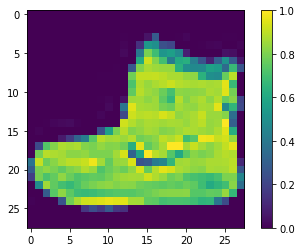

In [5]:
train_x, train_y, test_x, test_y = get_data()
train_x = train_x.reshape(-1, 1, cfg.image_height, cfg.image_width)
test_x = test_x.reshape(-1, 1, cfg.image_height, cfg.image_width)
train_x = train_x / 255.0
test_x = test_x / 255.0

print('训练数据集样本数：', train_x.shape[0])
print('测试数据集样本数：', test_y.shape[0])
print('通道数/图像长/宽：', train_x.shape[1:])
print('一张图像的标签样式：', train_y[0])  # 一共10类，用0-9的数字表达类别。

plt.figure()
plt.imshow(train_x[0,0,...])
plt.colorbar()
plt.grid(False)
plt.show()

In [6]:
# 转换数据类型为Dataset
def create_dataset():
    XY_train = list(zip(train_x, train_y))
    ds_train = ds.GeneratorDataset(XY_train, ['x', 'y'])
    ds_train = ds_train.shuffle(buffer_size=1000).batch(cfg.batch_size, drop_remainder=True)
    XY_test = list(zip(test_x, test_y))
    ds_test = ds.GeneratorDataset(XY_test, ['x', 'y'])
    ds_test = ds_test.shuffle(buffer_size=1000).batch(cfg.batch_size, drop_remainder=True)
    return ds_train, ds_test

In [7]:
# 定义卷积神经网络，无正则化
class ForwardFashion(nn.Cell):
    def __init__(self, num_class=10):  # 一共分十类，图片通道数是1
        super(ForwardFashion, self).__init__()
        self.num_class = num_class
        self.conv1 = nn.Conv2d(1, 32,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv2 = nn.Conv2d(32, 64,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv3 = nn.Conv2d(64, 128,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(128 * 11 * 11, 128)
        self.fc2 = nn.Dense(128, self.num_class)

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [8]:
# 定义卷积神经网络，有正则化
class ForwardFashionRegularization(nn.Cell):
    def __init__(self, num_class=10):  # 一共分十类，图片通道数是1
        super(ForwardFashionRegularization, self).__init__()
        self.num_class = num_class
        self.conv1 = nn.Conv2d(1, 32,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv2 = nn.Conv2d(32, 64,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv3 = nn.Conv2d(64, 128,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(3200, 128)
        self.bn = nn.BatchNorm1d(128)
        self.fc2 = nn.Dense(128, self.num_class)

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        x = self.dropout(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.bn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [9]:
def train(Net):
    ds_train, ds_test = create_dataset()
    # 构建网络
    network = Net(cfg.num_classes)
    # 定义模型的损失函数，优化器
    net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
    net_opt = nn.Adam(network.trainable_params(), cfg.lr)
    # 训练模型
    model = Model(network, loss_fn=net_loss, optimizer=net_opt, metrics={'acc': Accuracy()})
    loss_cb = LossMonitor()
    print("============== Starting Training ==============")
    model.train(30, ds_train, callbacks=[loss_cb], dataset_sink_mode=True)
    # 验证
    metric = model.eval(ds_test)
    print(metric)
    
    return model

In [10]:
# 训练无正则化的网络
model = train(ForwardFashion)

============== Starting Training ==============
epoch: 1 step: 937, loss is 0.44618028
epoch: 2 step: 937, loss is 0.22886054
epoch: 3 step: 937, loss is 0.13210446
epoch: 4 step: 937, loss is 0.20672263
epoch: 5 step: 937, loss is 0.0946552
epoch: 6 step: 937, loss is 0.17510523
epoch: 7 step: 937, loss is 0.16793618
epoch: 8 step: 937, loss is 0.069517665
epoch: 9 step: 937, loss is 0.08342023
epoch: 10 step: 937, loss is 0.056444228
epoch: 11 step: 937, loss is 0.0862963
epoch: 12 step: 937, loss is 0.08084622
epoch: 13 step: 937, loss is 0.13618313
epoch: 14 step: 937, loss is 0.05741894
epoch: 15 step: 937, loss is 0.019388027
epoch: 16 step: 937, loss is 0.014366223
epoch: 17 step: 937, loss is 0.11486755
epoch: 18 step: 937, loss is 0.012561982
epoch: 19 step: 937, loss is 0.010291649
epoch: 20 step: 937, loss is 0.08221265
epoch: 21 step: 937, loss is 0.02160878
epoch: 22 step: 937, loss is 0.094874114
epoch: 23 step: 937, loss is 0.035864547
epoch: 24 step: 937, loss is 0.0059

In [11]:
# 训练有正则化的网络
model = train(ForwardFashionRegularization)

============== Starting Training ==============
epoch: 1 step: 937, loss is 0.4416728
epoch: 2 step: 937, loss is 0.38747072
epoch: 3 step: 937, loss is 0.69458747
epoch: 4 step: 937, loss is 0.37273443
epoch: 5 step: 937, loss is 0.3485953
epoch: 6 step: 937, loss is 0.42782623
epoch: 7 step: 937, loss is 0.25521576
epoch: 8 step: 937, loss is 0.18834415
epoch: 9 step: 937, loss is 0.29044598
epoch: 10 step: 937, loss is 0.16157377
epoch: 11 step: 937, loss is 0.123149574
epoch: 12 step: 937, loss is 0.29526472
epoch: 13 step: 937, loss is 0.25381514
epoch: 14 step: 937, loss is 0.30744857
epoch: 15 step: 937, loss is 0.27070445
epoch: 16 step: 937, loss is 0.17147373
epoch: 17 step: 937, loss is 0.26714
epoch: 18 step: 937, loss is 0.16170019
epoch: 19 step: 937, loss is 0.16462994
epoch: 20 step: 937, loss is 0.23525417
epoch: 21 step: 937, loss is 0.43696648
epoch: 22 step: 937, loss is 0.17420335
epoch: 23 step: 937, loss is 0.2764947
epoch: 24 step: 937, loss is 0.2134682
epoch: 

In [12]:
# 预测
ds_test, _ = create_dataset()
test_ = ds_test.create_dict_iterator(output_numpy=True).get_next()
predictions = model.predict(Tensor(test_['x']))
predictions = predictions.asnumpy()
for i in range(15):
    p_np = predictions[i, :]
    p_list = p_np.tolist()
    print('第' + str(i) + '个sample预测结果：', p_list.index(max(p_list)), '   真实结果：', test_['y'][i])

第0个sample预测结果： 2    真实结果： 4
第1个sample预测结果： 5    真实结果： 5
第2个sample预测结果： 9    真实结果： 9
第3个sample预测结果： 9    真实结果： 9
第4个sample预测结果： 8    真实结果： 8
第5个sample预测结果： 8    真实结果： 8
第6个sample预测结果： 3    真实结果： 3
第7个sample预测结果： 3    真实结果： 3
第8个sample预测结果： 5    真实结果： 5
第9个sample预测结果： 8    真实结果： 8
第10个sample预测结果： 8    真实结果： 8
第11个sample预测结果： 6    真实结果： 2
第12个sample预测结果： 6    真实结果： 4
第13个sample预测结果： 5    真实结果： 5
第14个sample预测结果： 8    真实结果： 8


In [13]:
# -------------------定义可视化函数--------------------------------
# 输入预测结果序列，真实标签序列，以及图片序列
# 目标是根据预测值对错，让其标签显示为红色或者蓝色。对：标签为红色；错：标签为蓝色
def plot_image(predictions_array, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    # 显示对应图片
    plt.imshow(img, cmap=plt.cm.binary)
    # 显示预测结果的颜色，如果对上了是蓝色，否则为红色
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    # 显示对应标签的格式，样式
    plt.xlabel('{},{:2.0f}% ({})'.format(class_names[predicted_label],
                                         100 * np.max(predictions_array),
                                         class_names[true_label]), color=color)


In [14]:
# 将预测的结果以柱状图形状显示蓝对红错
def plot_value_array(predictions_array, true_label):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    this_plot = plt.bar(range(10), predictions_array, color='#777777')
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    this_plot[predicted_label].set_color('red')
    this_plot[true_label].set_color('blue')

In [15]:
import numpy as np
def softmax_np(x):
    x = x - np.max(x)
    exp_x = np.exp(x)
    softmax_x = exp_x/np.sum(exp_x)
    return softmax_x

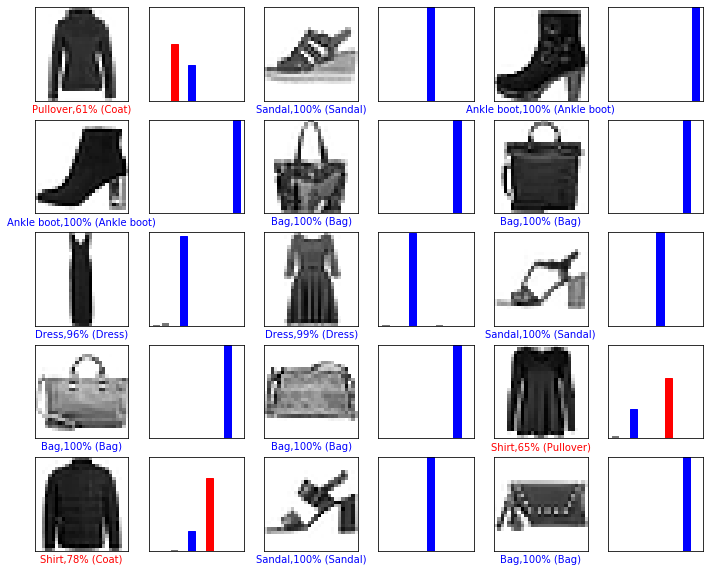

In [16]:
# 预测15个图像与标签，并展现出来
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    pred_np_ = predictions[i, :]
    pred_np_ = softmax_np(pred_np_)
    plot_image(pred_np_, test_['y'][i], test_['x'][i, 0, ...])
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(pred_np_, test_['y'][i])
plt.show()